In [338]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [339]:
words = open("names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [340]:
len(words)

32033

In [341]:
chars = sorted(list(set("".join(words))))
stoi = { s : i + 1 for i, s in enumerate(chars) }
stoi["."] = 0
itos = { i : s for s, i in stoi.items() }
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [342]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [343]:
Xtr, Ytr

(tensor([[ 0,  0,  0],
         [ 0,  0, 25],
         [ 0, 25, 21],
         ...,
         [15, 12,  4],
         [12,  4,  1],
         [ 4,  1, 14]]),
 tensor([25, 21,  8,  ...,  1, 14,  0]))

In [344]:
g = torch.Generator().manual_seed(2147483647)
embedding_dims = 10
n_chars = len(stoi) # including '.'
hidden_nodes = 200
C = torch.randn((n_chars, embedding_dims), generator = g)
W1 = torch.randn((embedding_dims * block_size, hidden_nodes), generator = g)
b1 = torch.randn(hidden_nodes, generator = g)
W2 = torch.randn((hidden_nodes, n_chars), generator = g)
b2 = torch.randn(n_chars, generator = g)
parameters = [C, W1, b1, W2, b2]

In [345]:
sum(p.nelement() for p in parameters)

11897

In [346]:
for p in parameters:
    p.requires_grad = True

In [347]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre

In [348]:
lri = []
lossi = []
stepi = []

In [349]:
for i in range(200000):
    # minibatch construction
    batch_size = 32
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, embedding_dims * block_size) @ W1 + b1)
    logits = h @ W2 + b2
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims = True)
    # # 32, 27
    # # 32,  1
    # loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())

    # backwards pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())
        
# print(loss.item())

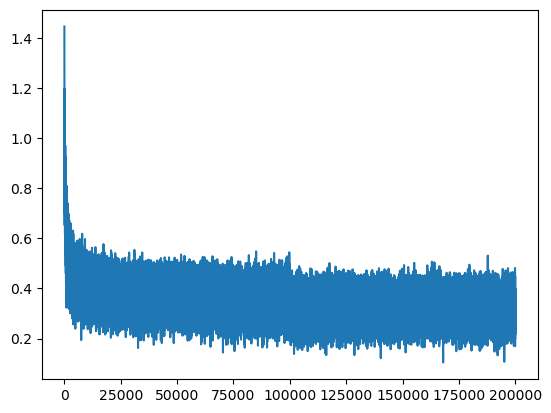

In [351]:
plt.plot(stepi, lossi)

In [352]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, embedding_dims * block_size) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1261, grad_fn=<NllLossBackward0>)

In [353]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, embedding_dims * block_size) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1693, grad_fn=<NllLossBackward0>)

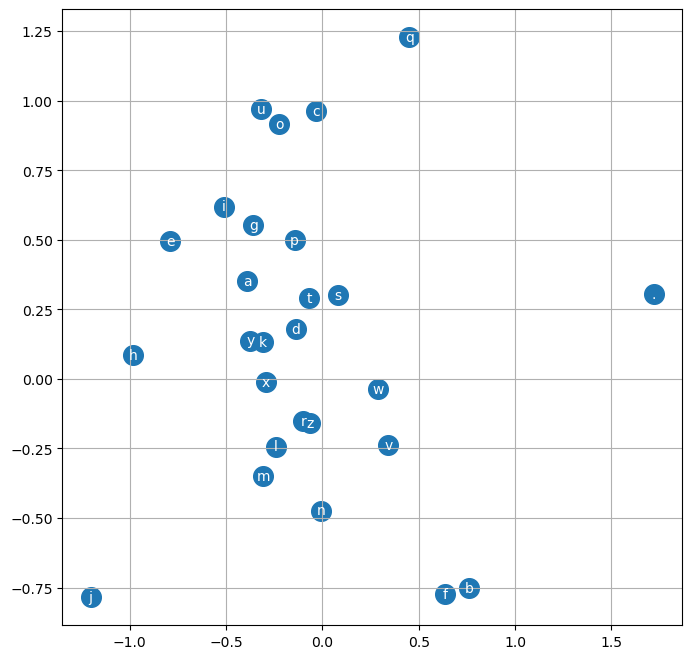

In [354]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [358]:
g = torch.Generator().manual_seed(2147483647 + 3)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim = 1)
        ix = torch.multinomial(probs, num_samples = 1, generator = g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
            
    print(''.join(itos[i] for i in out))

aries.
son.
xam.
folle.
maramani.
caliah.
micassor.
koyasana.
arty.
addie.
costy.
kenzastrie.
eza.
dav.
jeds.
ann.
sywa.
mari.
aidora.
thahioghana.
